# *Титков Даниил*
# *МКЛ17, 01.12.17*

# News clustering with KMeans

## Введение
Задача кластеризации относится к обучению без учителя. Кластерный анализ позволяет группировать наблюдения на основании их схожести без использования априорной информации об их разделении на категории. Тем не менее, интересно проверить, насколько эмпирическое разделение на группы будет соотвествовать известным тематикам.

### Цели работы
1. Проверить разбиение коллекции новостных статей на 28 кластеров с точки зрения соответствия известному разделению по описываемым событиям
2. Разделить коллекцию на меньшее количество групп и проинтерпретировать их

### Задачи
1. Первичный анализ, очистка и подготовка данных
2. Разбиение выборки на количество групп, соотвествующее количеству событий
3. Оптимизация параметров векторайзера
4. Определение оптимального количества кластеров
4. Разбиение выборки на выявленное количество кластеров и интерпретация результатов

In [1]:
import re
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.cm as cm
import seaborn as sns; sns.set()
import pymorphy2
import collections
import itertools

from tqdm import tqdm # прогресс-бар
from nltk.tokenize import word_tokenize
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.cluster import KMeans
from sklearn import metrics
from scipy.stats import mode
from mpl_toolkits.mplot3d import Axes3D # 3d графики

from jupyterthemes import jtplot #внешний вид ноутбука и графиков
jtplot.style(theme='grade3')
%matplotlib inline

## Загрузка и предобработка текстов

In [2]:
events = pd.read_csv('events.csv')
events.head(3)

,id,date,name
0,1,2017-01-10 00:00:00,Власти Петербурга согласились передать РПЦ Иса...
1,2,2017-01-20 00:00:00,Дональд Трамп вступил в должность президента США.
2,3,2017-02-20 00:00:00,Скоропостижно скончался постпред России при ОО...


In [3]:
news_raw = pd.merge(pd.read_csv('raw_news.csv'), 
                    events, 
                    left_on='event_id', 
                    right_on='id').drop(['Unnamed: 0','id'], axis=1)
news_raw.shape

(1930, 4)

In [4]:
news_raw.head(3)

,event_id,text,date,name
0,1,В ПЕТЕРБУРГЕ ПРОШЕЛ МИТИНГ ПРОТИВ ПЕРЕДАЧИ ИС...,2017-01-10 00:00:00,Власти Петербурга согласились передать РПЦ Иса...
1,1,"Lenta.co, Москва, 14 января 2017 СИТУАЦИЯ С П...",2017-01-10 00:00:00,Власти Петербурга согласились передать РПЦ Иса...
2,1,"Аргументы и Факты (aif.ru), Москва, 14 января...",2017-01-10 00:00:00,Власти Петербурга согласились передать РПЦ Иса...


### Поиск и удаление дубликатов

In [5]:
print(sum(news_raw.duplicated(subset='text')), 'дубликатов обнаружено')
news_raw[news_raw.duplicated(subset='text')].head(3)

6 дубликатов обнаружено


,event_id,text,date,name
513,9,"Коммерсантъ. Новости информ. центра, Москва, ...",2017-03-23 00:00:00,В центре Киева был убит бывший депутат Госдумы...
518,9,"Коммерсантъ. Новости информ. центра, Москва, ...",2017-03-23 00:00:00,В центре Киева был убит бывший депутат Госдумы...
522,9,"Коммерсантъ. Новости информ. центра, Москва, ...",2017-03-23 00:00:00,В центре Киева был убит бывший депутат Госдумы...


Так как все дубликаты относятся к одной категории, можно просто выкинуть повторяющиеся тексты, оставив один. 

In [6]:
news_raw_ = news_raw.drop_duplicates(subset='text', keep='first').copy()
news_raw_.shape

(1924, 4)

### Распределение новостей по событиям

In [7]:
# news_raw_.name.value_counts()

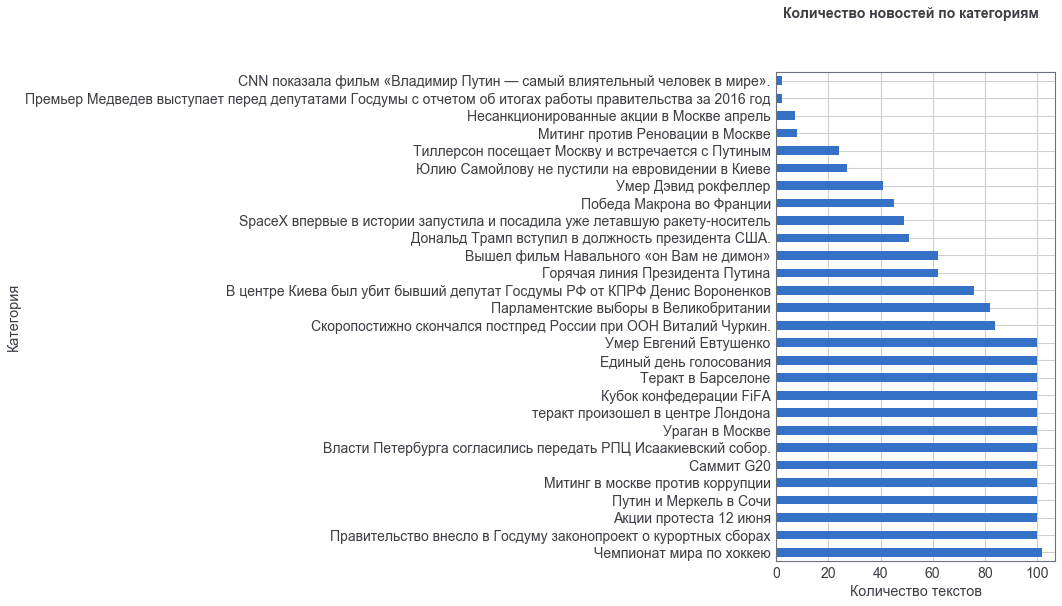

In [8]:
news_raw_.name.value_counts().plot(kind='barh', fontsize=14, figsize=(5,9))
plt.xlabel('Количество текстов')
plt.ylabel('Категория')
plt.suptitle('Количество новостей по категориям',fontsize=14, fontweight='bold');

Из графика видно, что некоторые события ассоциированы лишь с небольшим количеством статей. Маловероятно, что такие группы выделятся при автоматической кластеризации.

### Смотрим на длину текстов 

In [9]:
lens = np.array([len(t) for t in news_raw_.text]) #[1]
print('Mean:', lens.mean(),
      '\nMedian:', np.median(lens), '\nMin:', min(lens), '\nMax:', max(lens))

Mean: 3805.4527027 
Median: 1919.5 
Min: 31 
Max: 185698


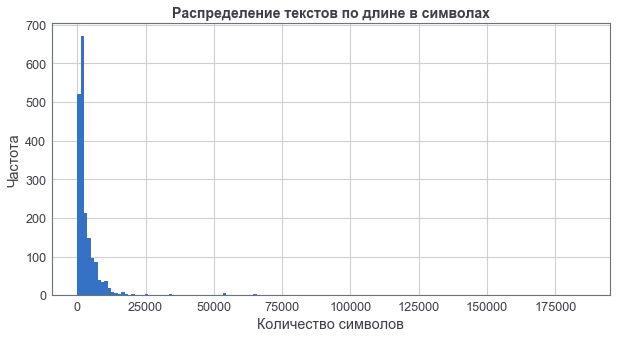

In [10]:
plt.figure(figsize=(10,5))
plt.hist(lens, bins=150)
plt.xlabel('Количество символов')
plt.ylabel('Частота')
plt.title(('Распределение текстов по длине в символах'), fontsize=14, fontweight='bold');

In [11]:
tr_up = 8000
print('{:.2f}% текстов короче {} букв' #[1]
      .format(lens[lens<tr_up].shape[0]/lens.shape[0]*100, tr_up))

91.22% текстов короче 8000 букв


In [12]:
tr_lo = 700
print('{:.2f}% текстов длиннее {} букв' #[1]
      .format(lens[lens>tr_lo].shape[0]/lens.shape[0]*100, tr_lo))

93.35% текстов длиннее 700 букв


### Лемматизация

Лемматизация - это приведение слова к нормальной форме (форме, которая обычно указывается в словаре). Например, слова "ем", "ел", "ела" будут приведены к форме "есть" и при векторизации текста будут обработаны как одно и то же слово, а не как разные. Для лемматизации будем использовать библиотеку **pymorphy2**. Определим соответствующую функцию и применим её к данным.

In [13]:
def lemmatize(string, perform=True): #with progress bar
    if not perform:
        return string
    morph = pymorphy2.MorphAnalyzer()
    text_n = [morph.parse(w)[0].normal_form for w in word_tokenize(string)]
    return ' '.join(text_n)

Так как лемматизация занимает время, будем сохранять лемматизированные данные в файл и загружать его, если он существует.

In [14]:
%%time 
try:
    news_lem = pd.read_csv('news_lem.csv').drop(['Unnamed: 0'], axis=1)
except FileNotFoundError:    
    news_lem = news_raw_.copy()
    tqdm.pandas(desc="Lemmatizer")
    news_lem.text = news_lem.text.progress_apply(lemmatize, perform=True)
    news_lem.to_csv('news_lem.csv', encoding='utf=8')

Wall time: 234 ms


In [15]:
news_lem.head(3)

,event_id,text,date,name
0,1,в петербург пройти митинг против передача исаа...,2017-01-10 00:00:00,Власти Петербурга согласились передать РПЦ Иса...
1,1,"lenta.co , москва , 14 январь 2017 ситуация с ...",2017-01-10 00:00:00,Власти Петербурга согласились передать РПЦ Иса...
2,1,"аргумент и факт ( aif.ru ) , москва , 14 январ...",2017-01-10 00:00:00,Власти Петербурга согласились передать РПЦ Иса...


In [16]:
news_lem.tail(3)

,event_id,text,date,name
1921,28,"lenta.ru , москва , 10 сентябрь 2017 кандидат ...",2017-09-10 00:00:00,Единый день голосования
1922,28,"lenta.ru , москва , 10 сентябрь 2017 медведев ...",2017-09-10 00:00:00,Единый день голосования
1923,28,"lenta.ru , москва , 10 сентябрь 2017 жириновск...",2017-09-10 00:00:00,Единый день голосования


### Очистка

Определим функцию для очистки текстов от ссылок, чисел и технических символов (например, знака процента).

In [17]:
def cleanse(s):
    rgxp = '[\`\)\(\|©~^<>/\'\"\«№#$&\*.,;=+?!\—_@:\]\[%\{\}0-9A-Za-z\\n]'
    return re.sub(' +', ' ', re.sub(rgxp, ' ', s.lower()))

In [18]:
cleanse(news_lem.text[2])[:300]

'аргумент и факт москва январь оппозиция провести митинг против передача исаакиевский собор рпц протестный мероприятие собрать около тысяча человек москва январь - аиф-москва депутат законодательный собрание санкт-петербург от фракция яблоко борис вишневский сообщить что январь перед исаакиевский соб'

In [19]:
tqdm.pandas(desc="Cleanse")
news_lem.text = news_lem.text.progress_apply(cleanse)

Cleanse: 100%|██████████████████████████████████████████| 1924/1924 [00:00<00:00, 1985.86it/s]


### Векторизация TF-IDF

Для того, чтобы применить алгоритм кластеризации к текстовым данным, нужно представить их в векторной форме. Будем использовать tf-idf векторизацию, которая позволяет учесть важность слова, соотнося частоту его появления в конкретном тексте и во всей коллекции. 

In [20]:
vectorizer = TfidfVectorizer(ngram_range=(1, 1), 
                             analyzer='word', 
                             lowercase=True,
                             tokenizer=word_tokenize, 
                             min_df = 100, 
                             max_df = 0.5,
                             max_features = 3000)

In [21]:
%%time
news_tfidf = vectorizer.fit_transform(news_lem.text)

Wall time: 7.09 s


In [22]:
print('{} наблюдений, {} признаков'.format(news_tfidf.shape[0], news_tfidf.shape[1]))

1924 наблюдений, 888 признаков


Посмотрим на несколько случайно выбранных слов из вошедших в набор признаков:

In [23]:
print('Всего вошло слов:', news_tfidf.shape[1])
np.array(vectorizer.get_feature_names()
)[np.random.randint(0, len(vectorizer.get_feature_names()), 20)]

Всего вошло слов: 888


array(['представить', 'русский', 'региональный', 'выбор', 'пора',
       'прошлое', 'кроме', 'дмитрий', 'причина', 'глава', 'сегодня',
       'евгений', 'онлайн-репортаж', 'играть', 'кто-то', 'над', 'объект',
       'просто', 'городской', 'соответствующий'],
      dtype='<U19')

И не вошедших:

In [24]:
print('Всего исключенных слов:', len(vectorizer.stop_words_))
np.array(list(vectorizer.stop_words_))[np.random.randint(0, len(vectorizer.stop_words_), 30)]

Всего исключенных слов: 23665


array(['свет', 'просматриваться', 'маяк', 'свалиться', 'заливка',
       'преждевременный', 'наотрез', 'единственно', 'рахимов',
       'подсознательно', 'наполовину', 'портал', 'цхинвал',
       'фальсифицировать', 'зациклиться', 'кемаленький', 'гривна',
       'политикан', 'рузаевский', 'гараж-ракушка', 'глубина',
       'разведданный', 'вузовский', 'имейл', 'бармин', 'гловера',
       'взломать', 'зарезать', 'литься', 'планетный'],
      dtype='<U43')

### Кластеризация К-средними

Перейдем непосредственно к кластеризации. Идея метода К-средних состоит в том, чтобы разделить наблюдений на К кластеров таким образом, чтобы суммарное квадратичное отклонение наблюдений от центров этих кластеров было минимальным. При этом число кластеров должно быть указано исследователем, что подходит для нашего случая, так как число групп известно. 

In [25]:
N = len(news_lem.event_id.unique())
print("Выделяем {} кластеров".format(N))

Выделяем 28 кластеров


In [26]:
km = KMeans(n_clusters=N, random_state=1)

In [27]:
%%time
km.fit(news_tfidf)

Wall time: 20.1 s


KMeans(algorithm='auto', copy_x=True, init='k-means++', max_iter=300,
    n_clusters=28, n_init=10, n_jobs=1, precompute_distances='auto',
    random_state=1, tol=0.0001, verbose=0)

Определим функцию для расчета метрик для оценки соответствия полученной кластеризации исходному разделению на группы. 
ARI (Adjusted Rand-Index) позволяет оценить схожесть двух разбиений на кластеры безотносительно названий групп с помощью анализа пар наблюдений, попавших при разбиениях в одну или разные группы. Гомогенность указывает, сколько объектов из кластера принадлежат к одному классу, полнота (completeness) - наоборот, сколько объектов из класса принадлежат к одному кластеру, V-measure (V-мера) - это гармоническое среднее гомогенности и полноты. 

In [28]:
def get_metrics(t_labels, labels, acc=True, print_mts=True):
    mts = {}
    if acc:
        mts["Accuracy"] = metrics.accuracy_score(t_labels, labels)
    mts["Homogeneity"] = metrics.homogeneity_score(t_labels, labels)
    mts["Completeness"] = metrics.completeness_score(t_labels, labels)
    mts["V-measure"] = metrics.v_measure_score(t_labels, labels)
    mts["Adjusted Rand-Index"] = metrics.adjusted_rand_score(t_labels, labels)
    if print_mts:
        for k, v in mts.items():
            print('{}: {:.3}'.format(k, v))
    return mts

Алгоритм кластеризации никак не учитывает группы, на которые разделены новости. Так что даже если мы задаем количество кластеров таким же, сколько у нас есть групп, это не значит, что соотвествующие группы будут иметь одну и ту же метку. Зададим функцию, чтобы решить эту проблему, после чего будет возможно построить матрицу ошибок и рассчитать метрики аккуратности, точности и полноты (recall) для каждого класса. 

In [29]:
def set_cluster_names(model, t_labels):
    labels = np.zeros_like(model.labels_) #[5]
    for i in range(model.get_params()['n_clusters']):
        mask = (model.labels_ == i)
        labels[mask] = mode(t_labels[mask])[0]
    return labels

Также зададим функцию для сокращения названий категорий новостей, чтобы можно было отобразить их на рисунке с матрицей ошибок. 

In [30]:
def shorten_names(series, k):
    return [(s[:k]+'..' if len(s)>k else s)+'({})'.format(list(series).index(s)+1) for s in series]

In [31]:
short_names = shorten_names(events.name, 25)

In [32]:
t_labels = news_lem.event_id
labels = set_cluster_names(km, t_labels)

In [33]:
get_metrics(t_labels, labels, acc=True);

Accuracy: 0.921
Homogeneity: 0.927
Completeness: 0.944
V-measure: 0.935
Adjusted Rand-Index: 0.89


In [34]:
mat = metrics.confusion_matrix(t_labels, labels) # [5]
correct = mat.diagonal().sum()
print('{} текстов ({:.2%}) классифицировано правильно'.format(correct, correct/len(t_labels)))

1772 текстов (92.10%) классифицировано правильно


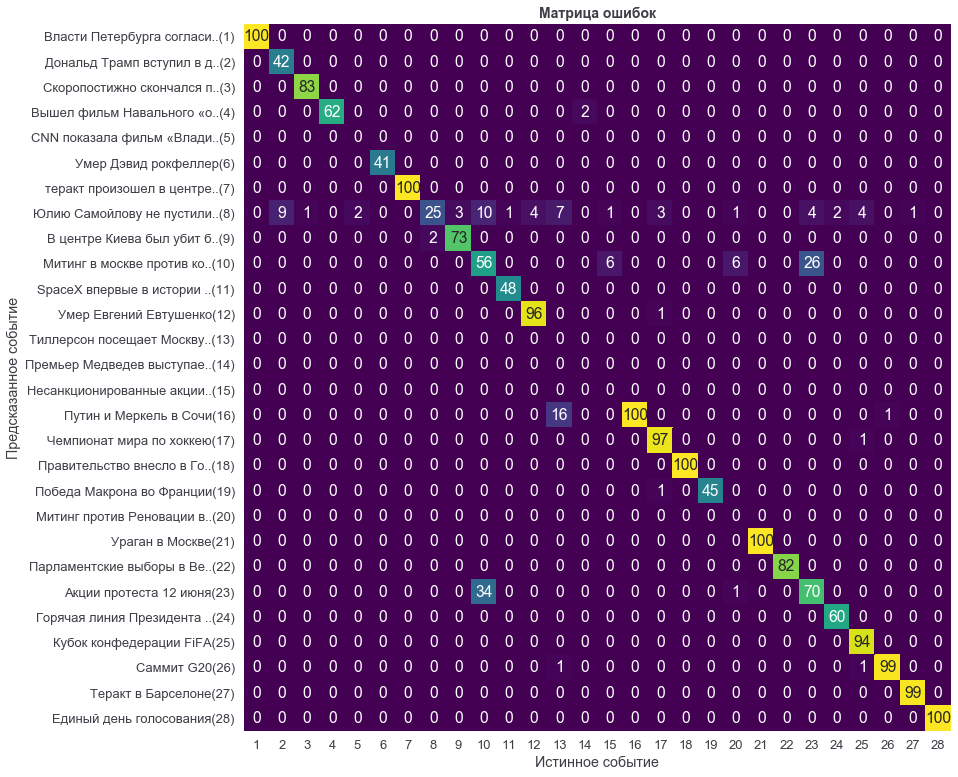

In [35]:
sns.set_context("talk")
plt.figure(figsize=(13,13))
sns.heatmap(mat.T, square=True, annot=True, fmt='d', cbar=False, 
            cmap='viridis',
            xticklabels=events.id,
            yticklabels=short_names)
plt.xlabel('Истинное событие')
plt.ylabel('Предсказанное событие')
plt.title(('Матрица ошибок'), fontsize=14, fontweight='bold');

In [36]:
print(metrics.classification_report(t_labels, 
                                    labels, 
                                    target_names=short_names))

c:\users\mytas\appdata\local\programs\python\python36\lib\site-packages\sklearn\metrics\classification.py:1135: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


                                 precision    recall  f1-score   support

 Власти Петербурга согласи..(1)       1.00      1.00      1.00       100
 Дональд Трамп вступил в д..(2)       1.00      0.82      0.90        51
 Скоропостижно скончался п..(3)       1.00      0.99      0.99        84
 Вышел фильм Навального «о..(4)       0.97      1.00      0.98        62
 CNN показала фильм «Влади..(5)       0.00      0.00      0.00         2
        Умер Дэвид рокфеллер(6)       1.00      1.00      1.00        41
 теракт произошел в центре..(7)       1.00      1.00      1.00       100
 Юлию Самойлову не пустили..(8)       0.32      0.93      0.48        27
 В центре Киева был убит б..(9)       0.97      0.96      0.97        76
Митинг в москве против ко..(10)       0.60      0.56      0.58       100
SpaceX впервые в истории ..(11)       1.00      0.98      0.99        49
     Умер Евгений Евтушенко(12)       0.99      0.96      0.97       100
Тиллерсон посещает Москву..(13)       0.00      0.

Для тех классов, к которым не отнесено ни одно наблюдение, метрики не определены и в таблице им приписаны нули. Видим, что такова ситуация для всех классов, в которых небольшое количество статей.

Из тех групп, в которых относительно много наблюдений, меньше всего соотвествуют исходному разделению по событиям группа №10 (Митинг в Москве против коррупции) и №23 (Акции протеста 12го июня), причем статьи, связанные с этими событиями, перепутанны именно между собой, а не с другими кластерами. Это ожидаемый результат, так как оба эти события - митинги против коррупции, очень близки по содержанию, результатам и реакции. 

### Поиск наилучших параметров векторайзера

В пакете sklearn реализован поиск оптимальных параметров для методов (по сетке) с помощью класса GridSearchCV. В данной работе, тем не менее, поиск был реализован без использования этого класса, так как это дает возможность более гибко подойти к отображению прогресса, назначать кластерам правильные имена и сразу выводить нужные метрики.

Параметры векторайзера в данном случае будут оцениваться относительно разбиения коллекции текстов на кластеры таким образом, чтобы полученные кластеры наиболее точно соотвествовали исходному разбиению по событиям. Данная процедура имеет представляет собой скорее исследовательский, нежели практический интерес, и её результаты не будут использоваться для решения дальнейших задач (т.к. там будет выбираться другое - меньшее - количество кластеров). 

In [37]:
def test_model(data, t_labels, min_dfs, max_fs, model, correct_names = True):
    vec_params = list(itertools.product(*[min_dfs, max_fs]))
    print("Размер выборки: {}\nВариантов: {}".format(len(data), len(vec_params)))
    results = pd.DataFrame({'Min df':[],
                            'Max features':[],
                            'Accuracy':[],
                            'Homogeneity':[],
                            'Completeness':[],
                            'V-measure':[],
                            'Adjusted Rand-Index':[]})
    for min_df, max_f in tqdm(vec_params):
        vectorizer = TfidfVectorizer(ngram_range=(1, 1), 
                                 analyzer='word', 
                                 lowercase=True,
                                 tokenizer=word_tokenize, 
                                 min_df = min_df, 
                                 max_df = 0.5,
                                 max_features = max_f)
        data_tfidf = vectorizer.fit_transform(data)
        clusters = model.fit_predict(data_tfidf)
        if correct_names:
            clusters = set_cluster_names(model, t_labels)
        params = {'Min df': min_df, 'Max features': max_f}
        mts = get_metrics(t_labels, clusters, acc=True, print_mts=False)
        results = pd.concat([results, pd.DataFrame({**params, **mts}, index=[0])], 
                            ignore_index=True)
    return results

In [38]:
%%time
data_ = news_lem
N = 28

# # небольшая выборка для отладки
# data_ = news_lem.sample(n=50, random_state=21)
# N = len(data_.event_id.unique())

results = test_model(data = data_.text, 
                     t_labels = data_.event_id, 
                     model = KMeans(n_clusters=N, random_state=1),
                     min_dfs = [0, 10, 20, 30, 50, 80, 100, 120, 150, 200], 
                     max_fs = [100, 300, 500, 1000, 2000, 3000],
                     correct_names=True)

Размер выборки: 1924
Вариантов: 60


100%|█████████████████████████████████████████████████████████| 60/60 [23:29<00:00, 23.49s/it]


Wall time: 23min 29s


In [39]:
results[results['Adjusted Rand-Index'] == results['Adjusted Rand-Index'].max()]

,Accuracy,Adjusted Rand-Index,Completeness,Homogeneity,Max features,Min df,V-measure
15,0.959979,0.920337,0.965687,0.950991,1000.0,20.0,0.958282


In [40]:
results[results['V-measure'] == results['V-measure'].max()]

,Accuracy,Adjusted Rand-Index,Completeness,Homogeneity,Max features,Min df,V-measure
11,0.940748,0.913863,0.969466,0.954157,3000.0,10.0,0.961751


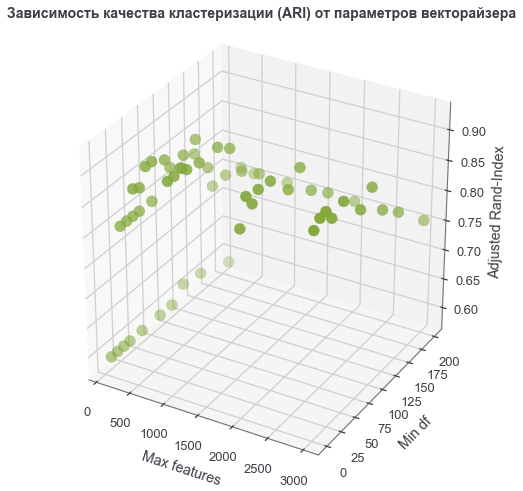

In [41]:
fig = plt.figure(figsize=(7,7)) # [7]
ax = fig.add_subplot(111, projection='3d')

ax.scatter(results['Max features'], 
           results['Min df'], 
           results['Adjusted Rand-Index'], 
           c='g', marker='o', s=120)

ax.set_xlabel('Max features', labelpad=15)
ax.set_ylabel('Min df', labelpad=15)
ax.set_zlabel('Adjusted Rand-Index', labelpad=15)

plt.suptitle('Зависимость качества кластеризации (ARI) от параметров векторайзера',
                 fontsize=14, fontweight='bold')
plt.tight_layout(); 

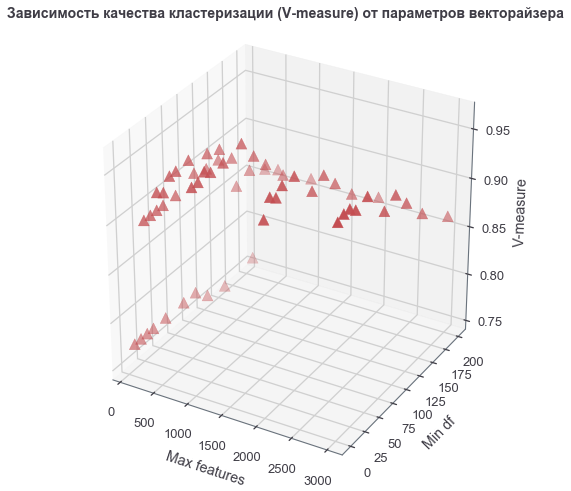

In [42]:
fig = plt.figure(figsize=(7,7)) # [7]
ax = fig.add_subplot(111, projection='3d')

ax.scatter(results['Max features'], 
           results['Min df'], 
           results['V-measure'], 
           c='r', marker='^', s=120)
    
ax.set_xlabel('Max features', labelpad=15)
ax.set_ylabel('Min df', labelpad=15)
ax.set_zlabel('V-measure', labelpad=15)

plt.suptitle('Зависимость качества кластеризации (V-measure) от параметров векторайзера', 
             fontsize=14, fontweight='bold')
plt.tight_layout(); 

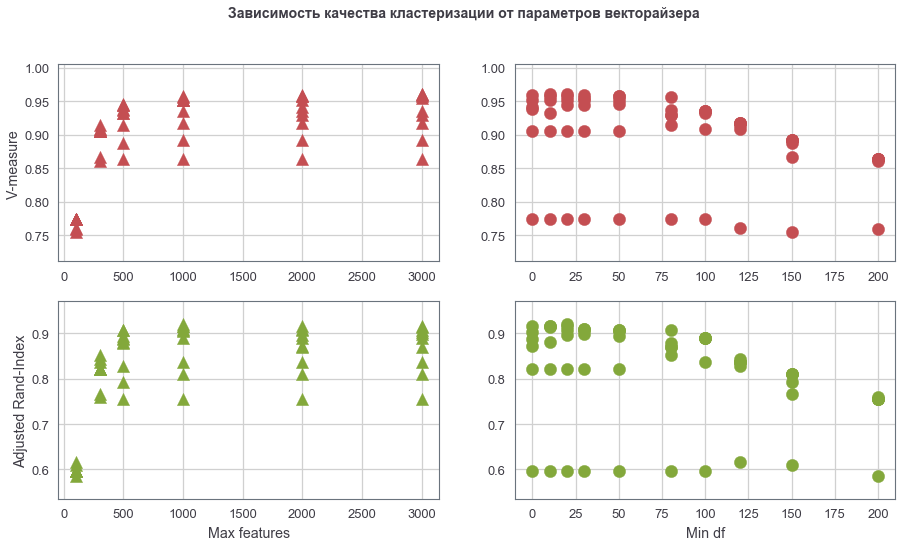

In [43]:
fig, axs = plt.subplots(2, 2)
fig.set_size_inches(15, 8)
axs[0,0].scatter(results['Max features'], results['V-measure'], c='r', marker='^', s=150)
axs[0,0].set_ylabel('V-measure', labelpad=3)
axs[0,1].scatter(results['Min df'], results['V-measure'], c='r', marker='o', s=150)
axs[1,0].scatter(results['Max features'], results['Adjusted Rand-Index'], c='g', marker='^', s=150)
axs[1,0].set_ylabel('Adjusted Rand-Index', labelpad=3)
axs[1,0].set_xlabel('Max features', labelpad=6)
axs[1,1].scatter(results['Min df'], results['Adjusted Rand-Index'], c='g', marker='o', s=150)
axs[1,1].set_xlabel('Min df', labelpad=6)
plt.suptitle('Зависимость качества кластеризации от параметров векторайзера', 
             fontsize=14, fontweight='bold');

Трехмерные графики выглядят привлекательно, однако труднее для интерпретации, чем двумерные. Так или иначе, по всем графикам видно, что показатели качества кластеризации положительно связаны с параметром Max features (чем больше признаков, тем точнее кластеризация) и отрицательно связаны с параметром Min df (то есть, чем меньше редких слов отсекается, тем точнее кластеризация - если считать исходное разделение на события за эталон). Это можно объяснить тем, что в данных имеется большое количество кластеров, на каждый из которых приходится совсем немного наблюдений. Однако эти тенденции наблюдаются только при крайних значениях параметров, а при умеренных (1000-3000 для числа признаков, 0-100 для Min df).

## Поиск оптимального числа кластеров

Следующей задачей будет разделение коллекции текстов на меньшее количество кластеров.

### Критерий каменной осыпи

Воспользуемая критерием каменной осыпи ("elbow method"). Ясно, что максимальное качество модели при использовании кластеризации методом К-средних достигается тогда, когда количество кластеров равно количеству наблюдений, однако такая модель не имеет смысла. Идея метода в том, чтобы остановиться на том количестве кластеров, после которого увеличение количества кластеров ведет к небольшому улучшению качества модели. 

Для этого построим график, на котором будут отображены суммарные квадратичные отклонения наблюдений от центроидов кластеров (V) для моделей с разным количеством кластеров (от 2 до 28). "Излом" на таком графике будет означать, что дальнейшее увеличение количества кластеров улучшает модель намного меньше, чем предыдущие шаги, а значит, имеет смысл остановиться на том количестве, после которого начинается излом (график становится более пологим).

100%|█████████████████████████████████████████████████████████| 27/27 [07:58<00:00, 17.73s/it]


Wall time: 7min 58s


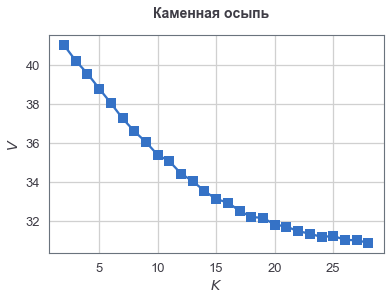

In [44]:
%%time
inertia = [] # [11]
for k in tqdm(range(2, 29)):
    kmeans = KMeans(n_clusters=k, random_state=1).fit(news_tfidf)
    inertia.append(np.sqrt(kmeans.inertia_))

plt.plot(range(2, 29), inertia, marker='s');
plt.xlabel('$K$')
plt.ylabel('$V$')
plt.suptitle("Каменная осыпь", fontsize=14, fontweight='bold');

Как видно из рисунка, заметных изломов на графике нет, и нельзя определить, где кончается "склон" и начиначется "осыпь". Так что для определения оптимального количества кластеров придется воспользоваться другим методом.

### Анализ силуэта

Попробуем определить оптимальное количество кластеров с помощью анализа коэффициентов силуэта (silhouette score). Значение коэффициента силуэта изменяется от - 1 до 1, где значения, приближающиеся к 1 означают, что объект в выборке хорошо соответствует своему кластеру и хорошо отделяется от соседнего кластера. Если значение коэффициента находится в районе 0, объект находится "на границе" между кластерами. Отрицательные показатели коэффициента свидетельствуют о том, что объект, возможно, приписан не к тому кластеру. [9, 10]

Для принятия решения об оптимальном количестве кластеров, построим графики, на которых отразим коэффициенты силуэта для каждого наблюдения для моделей от 2 до 10 кластеров. Хорошей будет считаться та модель, где большинство наблюдений во всех кластерах имеют положительные и не близкие к нулю коэффициенты. 

In [45]:
n_clusters = list(range(2, 11))
X = news_tfidf.todense()

Для 2 кластеров средний коэф. силуэта составляет: 0.034


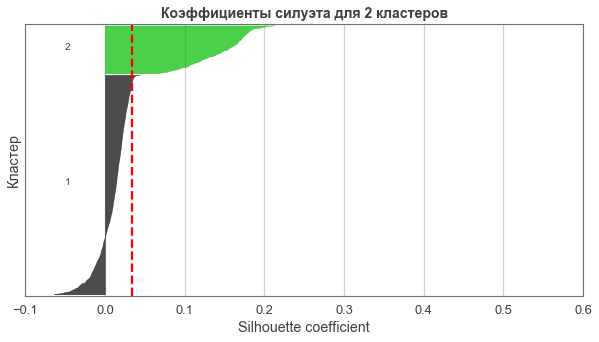

Для 3 кластеров средний коэф. силуэта составляет: 0.059


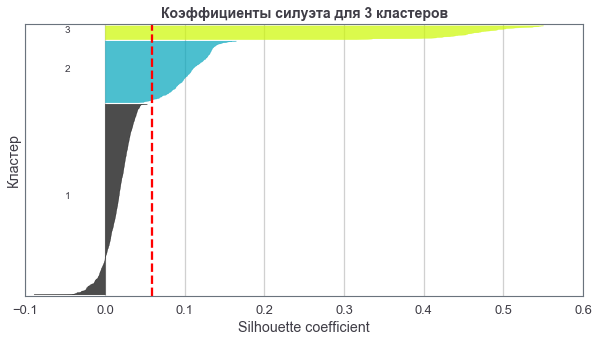

Для 4 кластеров средний коэф. силуэта составляет: 0.078


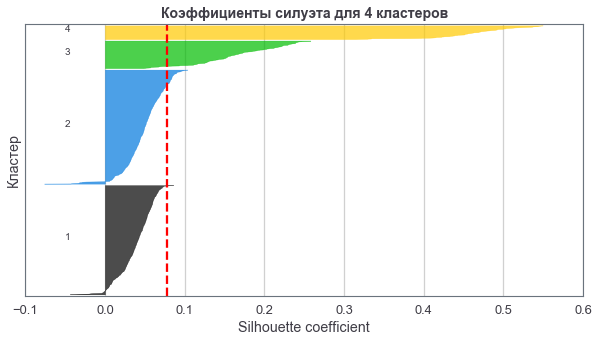

Для 5 кластеров средний коэф. силуэта составляет: 0.093


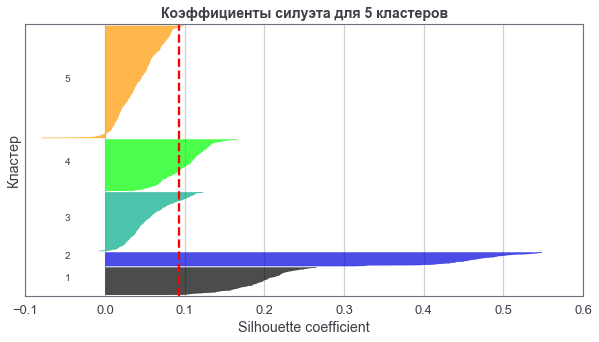

Для 6 кластеров средний коэф. силуэта составляет: 0.1


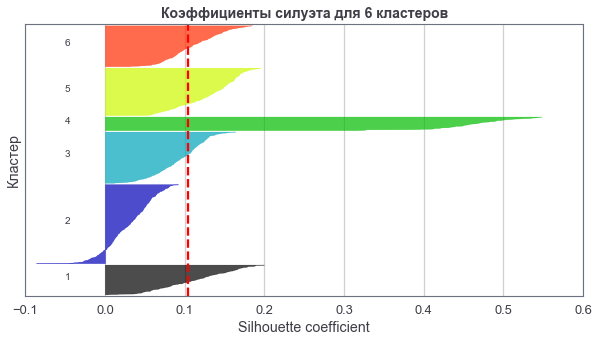

Для 7 кластеров средний коэф. силуэта составляет: 0.12


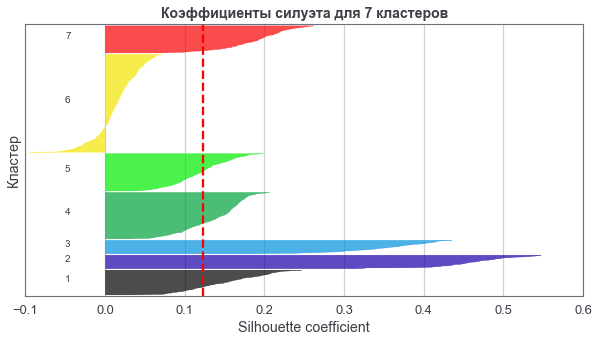

Для 8 кластеров средний коэф. силуэта составляет: 0.14


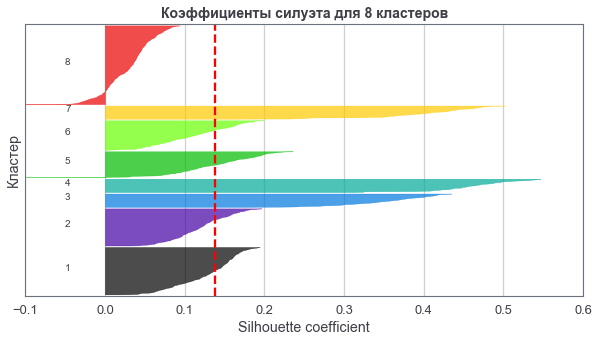

Для 9 кластеров средний коэф. силуэта составляет: 0.15


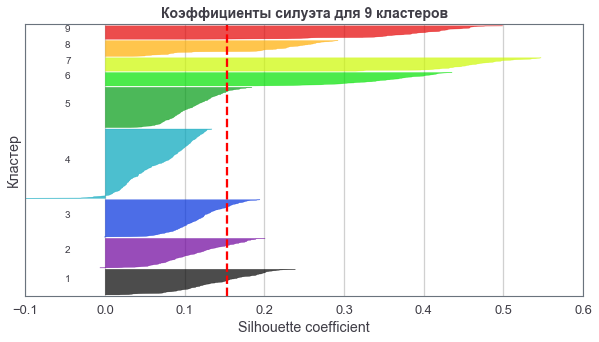

Для 10 кластеров средний коэф. силуэта составляет: 0.16


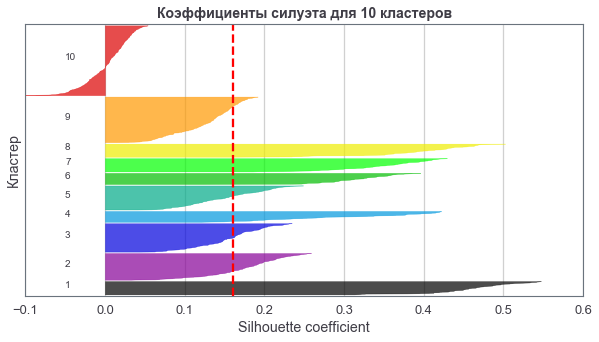

In [46]:
for n in n_clusters: # [10]
    fig, ax1 = plt.subplots(1, 1)
    fig.set_size_inches(10, 5)
    ax1.set_xlim([-0.1, 0.6])
    ax1.set_ylim([0, len(X) + (n + 1) * 10])
    clusterer = KMeans(n_clusters=n, random_state=1)
    cluster_labels = clusterer.fit_predict(X)
    silhouette_avg = metrics.silhouette_score(X, cluster_labels)
    print("Для {} кластеров средний коэф. силуэта составляет: {:.2}".format(n, silhouette_avg))
    sample_silhouette_values = metrics.silhouette_samples(X, cluster_labels)
    
    y_lower = 10
    for i in range(n):
        ith_cluster_silhouette_values = sample_silhouette_values[cluster_labels == i]

        ith_cluster_silhouette_values.sort()
        size_cluster_i = ith_cluster_silhouette_values.shape[0]
        y_upper = y_lower + size_cluster_i

        color = cm.spectral(float(i) / n)
        ax1.fill_betweenx(np.arange(y_lower, y_upper),
                          0, ith_cluster_silhouette_values,
                          facecolor=color, edgecolor=color, alpha=0.7)
        ax1.text(-0.05, y_lower + 0.5 * size_cluster_i, str(i+1), fontsize=10)
        y_lower = y_upper + 10
        
    ax1.set_xlabel("Silhouette coefficient")
    ax1.set_ylabel("Кластер")
    ax1.axvline(x=silhouette_avg, color="red", linestyle="--")
    ax1.set_yticks([])
    
    plt.title('Коэффициенты силуэта для {} кластеров'.format(n), fontsize=14, fontweight='bold')
    plt.show()

Как видно из графиков, более-менее равномерное распределение коэффициентов силуэта для объектов при котором нет кластеров, все объекты которого имеют низкий или отрицательный коэффициент, наблюдается при 4, 5, 6, 9 кластерах. Для моделей с большим числом кластеров во всех случаях наблюдается один кластер, значительная часть наблюдений в котором имеют отрицательный силуэт. Рассмотрим модели для 5 и 9 кластеров. 

## 5 кластеров

In [47]:
N=5
km = KMeans(n_clusters=N, random_state=21)

In [48]:
%%time
km.fit(news_tfidf)

Wall time: 16.3 s


KMeans(algorithm='auto', copy_x=True, init='k-means++', max_iter=300,
    n_clusters=5, n_init=10, n_jobs=1, precompute_distances='auto',
    random_state=21, tol=0.0001, verbose=0)

Выведем списки слов, близких к центрам каждого из полученных кластеров.

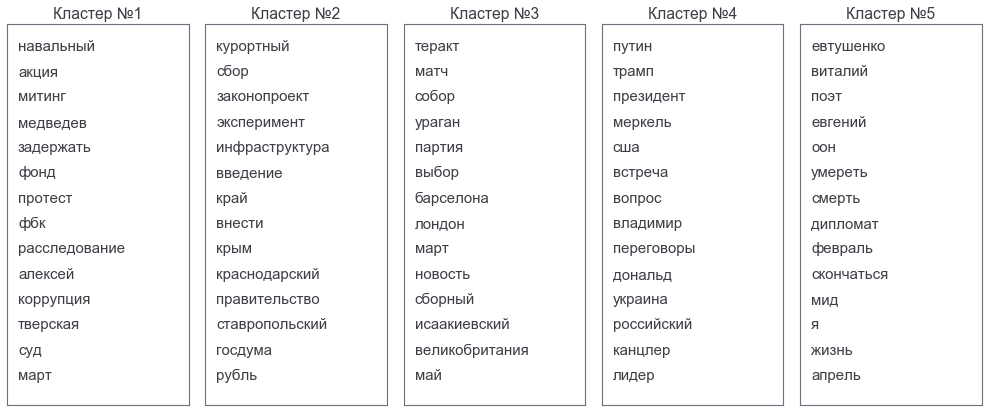

In [49]:
nwords = 14
order_centroids = km.cluster_centers_.argsort()[:, ::-1]
terms = vectorizer.get_feature_names()

plt.figure(figsize=(14,6)) # [6]
for t in range(N):
    plt.subplot(1, N, t + 1)
    plt.ylim(0, nwords + 1)  
    plt.xticks([]) 
    plt.yticks([]) 
    plt.title('Кластер №{}'.format(t+1))
    for i in range(nwords):
        plt.text(0.06, nwords-i, terms[order_centroids[t, :nwords][i]], fontsize=15)
plt.tight_layout();

Используя списки слов, проинтерпретируем полученные результаты. Какой смысл имеют эти группы?
1. В первую группу попали тексты, связанные с деятельностью ФБК и акциями против коррупции
2. Во вторую, судя по всему, тексты, описывающие события внутренней политики
3. В третью - крупные события, имеющие, в основном международное значение, - теракты, ураган, выборы.
4. В четвертой группе - события, связанные со внешней политикой 
5. В пятой группе - новости, касающиеся смерти отдельных известных людей

## 9 кластеров

In [50]:
N=9
km = KMeans(n_clusters=N, random_state=21)

In [51]:
%%time
km.fit(news_tfidf)

Wall time: 13.3 s


KMeans(algorithm='auto', copy_x=True, init='k-means++', max_iter=300,
    n_clusters=9, n_init=10, n_jobs=1, precompute_distances='auto',
    random_state=21, tol=0.0001, verbose=0)

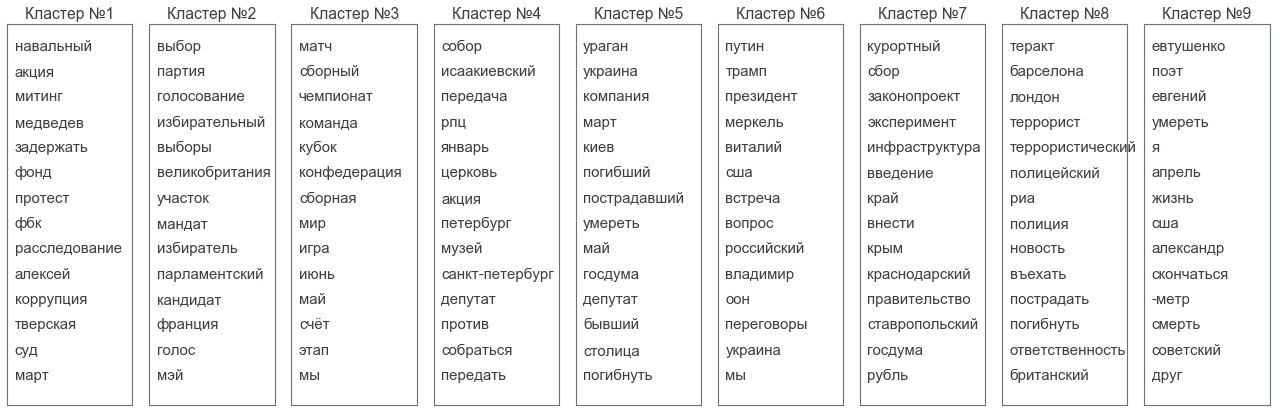

In [52]:
nwords = 14
order_centroids = km.cluster_centers_.argsort()[:, ::-1]

plt.figure(figsize=(18, 6)) # [6]
for t in range(N):
    plt.subplot(1, N, t + 1) 
    plt.ylim(0, nwords + 1)
    plt.xticks([]) 
    plt.yticks([]) 
    plt.title('Кластер №{}'.format(t+1))
    for i in range(nwords):
        plt.text(0.06, nwords-i, terms[order_centroids[t, :nwords][i]], fontsize=15)
plt.tight_layout();

Используя списки слов, проинтерпретируем полученные результаты. 
1. Протесты против коррупции, деятельность ФБК
2. Выборы в разных странах
3. Футбольные новости
4. Передача Исакиевского собора
5. Массовые трагедии 1 (стихийные бедствия)
6. Внешняя политики
7. Внутренняя политика
8. Массовые трагедии 2 (теракты)
9. Смерть отдельных известных людей

## Заключение
В ходе работы была проведена предварительная обработка текстов (лемматизация и очистка), векторизация с помощью TF-IDF, примен алгоритм кластеризации К-средними, проведено соотвествием между полученным разбиением на кластеры и исходными группами, сравнение результатов при разных параметрах векторайзера, реализован вывод признаков (слов), помогающих проинтерпретировать смысл полученных кластеров. 

### Выводы
1. Из 28 категорий при кластеризации К-средними воспроизводятся 23, при этом 11 из них воспоизводятся с точностью близкой к 100%. Не воспроизводятся категории с небольшим числом наблюдений. 
2. При разбиении на меньшее количество кластеров (5 и 9) получаются легко интерпретируемые группы, особенно в модели с 9 кластерами. В случае с 5 кластерами один из кластеров (№3) представляется противоречивым. 

### Ограничения
- При предобработке текстов числовые составляющие дат были просто удалены. Другим вариантом работы с ними могло быть приведение их к стандартной форме
- Не был использован список стоп-слов для русского языка
- Выбор начальных центроидов кластеров в K-means случаен и является нестабильным. Для стабилизации результатов без увеличения времени рассчетов в работе использовалась фиксация состояния генератора псевдослучайных чисел. Более правильным вариантом, однако, было бы многократное выполнение алгоритма с последующим усреднением результатов. 
- Изменение параметров векторайзера может влиять на результаты анализа силуэта и критерия каменной осыпи; степень и пределы этого влияния не были обстоятельно изучены

### Варианты продолжения работы
- Изучить, как соотносятся модели с небольшим количеством кластеров и исходное разделение новостей на события. В какие кластеры попали статьи только про одно событие, а какие объединяют несколько? 
- Проверить воспроизводимость других осмысленных группировок новостных статей (не по событиям, а, например, по сферам жизни общества или по действующим лицам) при автоматической кластеризации.
- Поэкспериментировать с предподготовкой - например, сохранить цифры и знаки процента в текстах.
- Поэкспериментировать с параметрами алгоритма KMeans и векторайзера tf-idf. 
- Использовать другие методы приведения текстов к векторному виду (count vectorizer, word2vec) и их преобразования после этого (SVD, нормализация)
- Использовать другие методы кластеризации (иерархическая кластеризация, спектральная кластеризация  и др.)

## Источники и образцы
В ходе работы были использованы теоретические соображения и методы из следующих источников (ссылки проставлены в виде коментариев с номером источника: [1]) 
1. https://github.com/EvgenyKashin/CommentsAnalysis
2. http://nlpforhackers.io/recipe-text-clustering/
3. http://scikit-learn.org/stable/auto_examples/text/document_clustering.html
4. https://pythonprogramminglanguage.com/kmeans-text-clustering/
5. https://jakevdp.github.io/PythonDataScienceHandbook/05.11-k-means.html
6. https://de.dariah.eu/tatom/topic_model_visualization.html
7. https://matplotlib.org/examples/mplot3d/scatter3d_demo.html
8. http://scikit-learn.org/stable/modules/generated/sklearn.model_selection.GridSearchCV.html
9. https://en.wikipedia.org/wiki/Silhouette_(clustering)
10. http://scikit-learn.org/stable/auto_examples/cluster/plot_kmeans_silhouette_analysis.html
11. https://habrahabr.ru/company/ods/blog/325654/